In [1]:
import pandas as pd
df = pd.read_csv('data/title_conference.csv')
df

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS
...,...,...
2502,A new QR-decomposition based recursive frequen...,ISCAS
2503,CNN Implementation of Spin Filters for Electro...,ISCAS
2504,FaceKit: A Database Interface Design Toolkit.,VLDB
2505,On the trade-off between the number of scrolls...,ISCAS


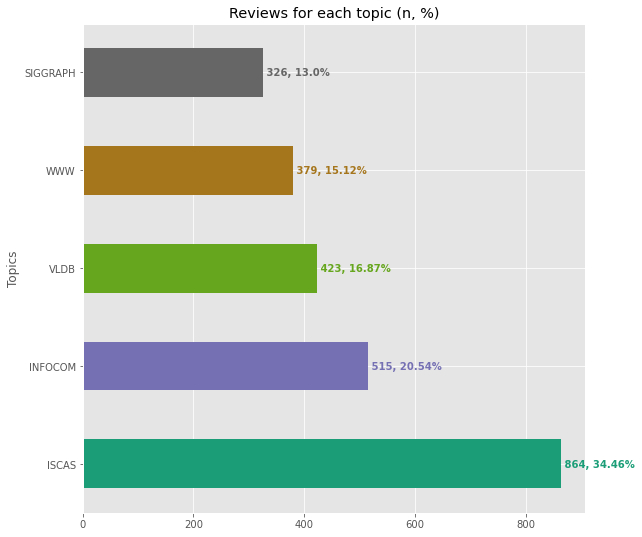

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df["Conference"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['Conference'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['Conference'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [3]:
# map topic descriptions to labels
df['Labels'] = df['Conference'].map({'VLDB': 0,
                                            'ISCAS': 1,
                                            'WWW': 2,
                                            'INFOCOM': 3,
                                            'SIGGRAPH': 4})

# drop unused column
df = df.drop(["Conference"], axis=1)

df.head()

,Title,Labels
0,Innovation in Database Management: Computer Sc...,0
1,High performance prime field multiplication fo...,1
2,enchanted scissors: a scissor interface for su...,4
3,Detection of channel degradation attack by Int...,3
4,Pinning a Complex Network through the Betweenn...,1


In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['Title'], y, test_size=0.25)

In [31]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [5]:
#!pip install --upgrade tensorflow-hub --user
#!pip install tensorflow-text --user

In [8]:
# for Colab users: !pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")




In [9]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Tracing Ray Differentials"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.91669315, -0.4999302 , -0.9260885 ,  0.8884539 ,  0.7043692 ,
        -0.28499526,  0.90300685,  0.34367839, -0.69107527, -0.9999938 ,
        -0.52011305,  0.9474084 ,  0.98771214,  0.47673216,  0.90814644,
        -0.850604  , -0.6297139 , -0.57352024,  0.35162348, -0.6045588 ,
         0.7069809 ,  0.9999924 , -0.04585685,  0.4592474 ,  0.4466498 ,
         0.9816654 , -0.8080609 ,  0.91028184,  0.95016474,  0.7953834 ,
        -0.7317973 ,  0.42623332, -0.99269694, -0.23432831, -0.9244662 ,
        -0.993447  ,  0.63937396, -0.7370606 ,  0.08111405, -0.14353317,
        -0.86502177,  0.58490187,  0.9999794 , -0.5025435 ,  0.63197833,
        -0.32833692, -1.        ,  0.2494013 , -0.9258572 ,  0.8882883 ,
         0.837989  ,  0.8399062 ,  0.26285812,  0.5455792 ,  0.56103724,
        -0.47025433, -0.03076094,  0.17141762, -0.3759665 , -0.54772997,
        -0.58188015,  0.5827458 , -0.78185624, -0.88244545,  0.87528414,
 

In [14]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Title')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [17]:
n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.Recall(name="recall"),
      tf.keras.metrics.Precision(name="precision")
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)
with tf.device('/gpu:0'):
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = METRICS)

    model_fit = model.fit(x_train, 
                          y_train, 
                          epochs = n_epochs,
                          validation_data = (x_test, y_test),
                          callbacks = [earlystop_callback])

Epoch 1/5
59/59 [==============================] - 555s 9s/step - loss: 1.4795 - accuracy: 0.3745 - recall: 0.1154 - precision: 0.5651 - val_loss: 1.3537 - val_accuracy: 0.4657 - val_recall: 0.0606 - val_precision: 0.9048
Epoch 2/5
59/59 [==============================] - 549s 9s/step - loss: 1.4583 - accuracy: 0.3968 - recall: 0.1362 - precision: 0.5651 - val_loss: 1.2956 - val_accuracy: 0.4657 - val_recall: 0.1818 - val_precision: 0.7808
Epoch 3/5
59/59 [==============================] - 545s 9s/step - loss: 1.4025 - accuracy: 0.4298 - recall: 0.1457 - precision: 0.6227 - val_loss: 1.3125 - val_accuracy: 0.4498 - val_recall: 0.2807 - val_precision: 0.7243
Epoch 4/5
59/59 [==============================] - 548s 9s/step - loss: 1.3731 - accuracy: 0.4436 - recall: 0.1766 - precision: 0.6472 - val_loss: 1.2456 - val_accuracy: 0.4785 - val_recall: 0.2807 - val_precision: 0.7652
Epoch 5/5
59/59 [==============================] - 546s 9s/step - loss: 1.3410 - accuracy: 0.4638 - recall: 0.18

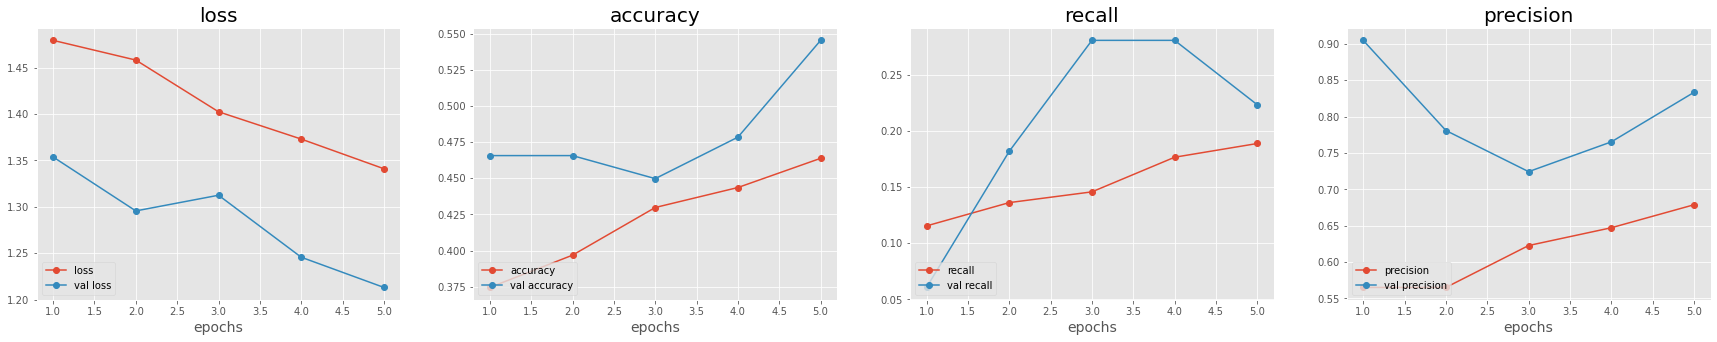

In [18]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [19]:
# test prediction on some newly generated reviews
reviews = [
    "Innovation in Database Management: Computer Science vs. Engineering.",
"High performance prime field multiplication for GPU.",
"enchanted scissors: a scissor interface for support in cutting and interactive fabrication.",
"Detection of channel degradation attack by Intermediary Node in Linear Networks.",
"Pinning a Complex Network through the Betweenness Centrality Strategy."
]

In [21]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)

1/1 [==============================] - 1s 1s/step


[3, 1, 1, 1, 3]

In [30]:
y_pred

[1,
 1,
 2,
 3,
 4,
 3,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 3,
 2,
 3,
 3,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 3,
 1,
 4,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 3,
 2,
 2,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 2,
 3,
 2,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 3,
 2,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 2,
 3,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 2,
 1,
 3,
 1,
 3,
 3,
 4,
 1,
 2,
 3,
 1,
 3,
 2,
 1,
 3,
 3,
 1,
 1,
 3,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 4,
 1,
 3,
 1,


In [28]:
from sklearn.metrics import classification_report


y_pred = predict_class(x_test)


20/20 [==============================] - 133s 7s/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [34]:
print(classification_report(np.argmax(y_test,axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.67      0.02      0.04       106
           1       0.57      0.93      0.71       225
           2       0.47      0.43      0.45        98
           3       0.50      0.63      0.55       123
           4       0.80      0.16      0.27        75

    accuracy                           0.55       627
   macro avg       0.60      0.43      0.40       627
weighted avg       0.59      0.55      0.47       627



In [35]:
###save load model
model.save("/models/text_classifier_v1")

###load
from tensorflow import keras

# load model
new_model = keras.models.load_model("/models/text_classifier_v1")

# test predictions
[np.argmax(pred) for pred in new_model.predict(reviews)]
# output: [3, 1, 0]

INFO:tensorflow:Assets written to: /models/text_classifier_v1\assets


INFO:tensorflow:Assets written to: /models/text_classifier_v1\assets


1/1 [==============================] - 1s 1s/step


[3, 1, 1, 1, 3]

In [42]:
# load blind set
test_set = pd.read_csv('data/test_conference.csv')

test_set.head()

,Title,Conference
0,Specifying and Enforcing Intertask Dependencies.,VLDB
1,VLSI decoding architecture with improved conve...,ISCAS
2,Detecting the origin of text segments efficien...,WWW
3,Delay Tolerant Event Collection in Sensor Netw...,INFOCOM
4,Active noise cancellation of motion artifacts ...,ISCAS


In [43]:
# map topic descriptions to labels
test_set['Labels'] = test_set['Conference'].map({'VLDB': 0,
                                            'ISCAS': 1,
                                            'WWW': 2,
                                            'INFOCOM': 3,
                                            'SIGGRAPH': 4})

# drop unused column
test_set = test_set.drop(["Conference"], axis=1)

test_set

,Title,Labels
0,Specifying and Enforcing Intertask Dependencies.,0
1,VLSI decoding architecture with improved conve...,1
2,Detecting the origin of text segments efficien...,2
3,Delay Tolerant Event Collection in Sensor Netw...,3
4,Active noise cancellation of motion artifacts ...,1
5,User-Centered Modeling of Interactive Web Sites.,2
6,Automatic matchmaking of web services.,2
7,Structural analysis of the emerging event-web.,2
8,When Speed Has a Price: Fast Information Extra...,0
9,Capturing Global Transactions from Multiple Re...,0


In [45]:
from sklearn.metrics import classification_report


y_pred = predict_class(test_set["Title"])
print(classification_report(test_set["Labels"], y_pred))

2/2 [==============================] - 7s 7s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.64      0.82      0.72        11
           2       0.71      0.56      0.63         9
           3       0.14      0.50      0.22         2
           4       0.75      0.60      0.67         5

    accuracy                           0.55        33
   macro avg       0.45      0.49      0.45        33
weighted avg       0.53      0.55      0.52        33

